In [1]:
!pip install transformers
!pip install fitz
!pip install spacy
!pip install PyMuPDF
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 24.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
 

In [1]:
import re
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd
from nltk.corpus import stopwords

In [2]:
import nltk
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


EXPLORATORY DATA ANALYSIS

In [3]:
import string
import re
# Function to clean text
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

DEFINING REGEX PATTERNS, VALIDATING THE MATCH

In [4]:
nlp = spacy.load("en_core_web_sm")

supernova_name_pattern = re.compile(r'\bSN\d{4}[A-Za-z]*\b')
type_pattern = re.compile(r'\bType [I|II][a-c|p|n|l|b]?\b')
luminosity_pattern = re.compile(r'-?\d+\.\d+ mag')
host_galaxy_pattern = re.compile(r'NGC \d+|IC \d+|Messier \d+|UGC \d+|ESO \d+-\d+|PGC \d+|Mrk \d+|SDSS J\d+|RX J\d+|2MASX J\d+|A\d+|PKS \d+')
redshift_pattern = re.compile(r'z=\d+\.\d+')
distance_pattern = re.compile(r'\d+\.\d+ Mpc')

def validate_entity(entity, label):
    supernova_name_pattern = re.compile(r'^SN\d{4}[A-Za-z]*$')
    type_pattern = re.compile(r'^Type [I|II][a-c|p|n|l|b]?$')
    luminosity_pattern = re.compile(r'^-?\d+\.\d+ mag$')
    host_galaxy_pattern = re.compile(r'^(NGC \d+|IC \d+|Messier \d+|UGC \d+|ESO \d+-\d+|PGC \d+|Mrk \d+|SDSS J\d+|RX J\d+|2MASX J\d+|PKS \d+)$')
    redshift_pattern = re.compile(r'^z=\d+\.\d+$')
    distance_pattern = re.compile(r'^\d+\.\d+ Mpc$')


    if label == "Supernova Name" and supernova_name_pattern.match(entity):
        return True
    elif label == "Type" and type_pattern.match(entity):
        return True
    elif label == "Luminosity" and luminosity_pattern.match(entity):
        return True
    elif label == "Host Galaxy" and host_galaxy_pattern.match(entity):
        return True
    elif label == "Redshift" and redshift_pattern.match(entity):
        return True
    elif label == "Distance" and distance_pattern.match(entity):
        return True


    return False

DEFINING RULE BASED ANNOTATION

In [5]:
def initial_annotation(text):
    annotations = []

    supernova_names = supernova_name_pattern.findall(text)
    types = type_pattern.findall(text)
    luminosities = luminosity_pattern.findall(text)
    host_galaxies = host_galaxy_pattern.findall(text)
    redshifts = redshift_pattern.findall(text)
    distances = distance_pattern.findall(text)

    annotations.extend([("Supernova Name", name) for name in supernova_names if validate_entity(name, "Supernova Name")])
    annotations.extend([("Type", type_) for type_ in types if validate_entity(type_, "Type")])
    annotations.extend([("Luminosity", lum) for lum in luminosities if validate_entity(lum, "Luminosity")])
    annotations.extend([("Host Galaxy", galaxy) for galaxy in host_galaxies if validate_entity(galaxy, "Host Galaxy")])
    annotations.extend([("Redshift", redshift) for redshift in redshifts if validate_entity(redshift, "Redshift")])
    annotations.extend([("Distance", distance) for distance in distances if validate_entity(distance, "Distance")])

    return annotations

TOKENIZING AND CHUNKING

In [6]:
def tokenize_and_chunk(text, tokenizer, max_length=512):
    tokens = tokenizer(text, truncation=True, max_length=max_length, return_overflowing_tokens=False, return_tensors='pt')
    input_ids = tokens['input_ids']
    chunks = [tokenizer.decode(input_ids[0][i:i + max_length], skip_special_tokens=True) for i in range(0, len(input_ids[0]), max_length)]
    return chunks

NER ANNOTATION

In [7]:
def ner_annotation(text):
    tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
    model = AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_uncased")
    nlp_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)


    chunks = tokenize_and_chunk(text, tokenizer)
    all_results = []

    for chunk in chunks:
        if chunk.strip():
            results = nlp_pipeline(chunk)
            for result in results:
                word = result['word']
                entity = result['entity']


                label = None
                if "SN" in word:
                    label = "Supernova Name"
                elif "Type" in word:
                    label = "Type"
                elif "mag" in word:
                    label = "Luminosity"
                elif "z=" in word:
                    label = "Redshift"
                elif "Mpc" in word:
                    label = "Distance"
                elif any(prefix in word for prefix in ["NGC", "IC", "Messier", "UGC", "ESO", "PGC", "Mrk", "SDSS", "RX", "2MASX", "PKS"]):
                    label = "Host Galaxy"

                if label and validate_entity(word, label):
                    all_results.append((word, label))

    return all_results

COMBINING THE ANNOTATIONS

In [8]:
def combined_annotation(text):
    if not text.strip():
        return []

    rule_based_anns = initial_annotation(text)
    ner_anns = ner_annotation(text)

    combined_anns = list(set(rule_based_anns + ner_anns))

    valid_annotations = [ann for ann in combined_anns if validate_combined_annotation(ann)]

    return valid_annotations


def validate_combined_annotation(annotation):
    return True

FUNCTION TO EXTRACT TEXT FROM PDF

In [10]:
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 55.7 MB/s eta 0:00:00


In [11]:
def extract_text_from_pdf(pdf_path):
    import fitz
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(doc.page_count):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

def process_pdfs(pdf_paths):
    all_annotations = []

    for pdf_path in pdf_paths:
        text = extract_text_from_pdf(pdf_path)
        if text.strip():
            annotations = combined_annotation(text)
            all_annotations.extend(annotations)

    return all_annotations


pdf_paths = ['/content/sample_data/Supernovae_dataset/0303428v1.pdf',
             '/content/sample_data/Supernovae_dataset/0601261v1.pdf',
             '/content/sample_data/Supernovae_dataset/0611295v2.pdf',
             '/content/sample_data/Supernovae_dataset/0612072v1.pdf',
             '/content/sample_data/Supernovae_dataset/0706.4088v1.pdf',
             '/content/sample_data/Supernovae_dataset/0708.2749v1.pdf',
             '/content/sample_data/Supernovae_dataset/0801.3297v3.pdf',
             '/content/sample_data/Supernovae_dataset/0905.4125v1.pdf',
             '/content/sample_data/Supernovae_dataset/0907.4524v1.pdf',
             '/content/sample_data/Supernovae_dataset/0908.4277v1.pdf',
             '/content/sample_data/Supernovae_dataset/0910.5597v2.pdf',
             '/content/sample_data/Supernovae_dataset/1211.1378v1.pdf',
             '/content/sample_data/Supernovae_dataset/1803.01875v2.pdf',
             '/content/sample_data/Supernovae_dataset/1805.03207v1.pdf',
             '/content/sample_data/Supernovae_dataset/2103.05230v1.pdf',
             '/content/sample_data/Supernovae_dataset/2105.00665v2.pdf',
             '/content/sample_data/Supernovae_dataset/2312.04621v2.pdf',
             '/content/sample_data/Supernovae_dataset/2407.03721v1.pdf',
             '/content/sample_data/Supernovae_dataset/2408.06287v1.pdf',
             '/content/sample_data/Supernovae_dataset/9805201v1.pdf'
             ]
annotations = process_pdfs(pdf_paths)


for ann in annotations:
    print(ann)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert

('Luminosity', '0.12 mag')
('Luminosity', '0.04 mag')
('Luminosity', '0.7 mag')
('Type', 'Type Ia')
('Luminosity', '0.25 mag')
('Luminosity', '19.5 mag')
('Luminosity', '0.6 mag')
('Supernova Name', 'SN1895B')
('Supernova Name', 'SN1972E')
('Supernova Name', 'SN1987A')
('Supernova Name', 'SN1998eq')
('Supernova Name', 'SN1989B')
('Supernova Name', 'SN1992bi')
('Supernova Name', 'SN1960F')
('Supernova Name', 'SN1991T')
('Supernova Name', 'SN1937C')
('Luminosity', '0.2 mag')
('Supernova Name', 'SN1999em')
('Supernova Name', 'SN1974G')
('Luminosity', '0.01 mag')
('Luminosity', '0.06 mag')
('Supernova Name', 'SN1981B')
('Supernova Name', 'SN1999by')
('Supernova Name', 'SN1990N')
('Supernova Name', 'SN1991bg')
('Supernova Name', 'SN1998bu')
('Luminosity', '22.1 mag')
('Supernova Name', 'SN1986G')
('Luminosity', '0.02 mag')
('Type', 'Type I')
('Type', 'Type Ia')
('Luminosity', '33.46 mag')
('Luminosity', '19.4 mag')
('Luminosity', '0.04 mag')
('Luminosity', '0.03 mag')
('Luminosity', '0.27 m

STORING ENTITIES AS RECORDS

In [13]:
all_extracted_records = []

current_record = {"Supernova Name": None, "Luminosity": None, "Type": None, "Host Galaxy": None, "Redshift": None, "Distance": None}

for label, entity in annotations:
    if label == "Supernova Name":

        if current_record["Supernova Name"] is not None:
            all_extracted_records.append(current_record)

            current_record = {"Supernova Name": None, "Luminosity": None, "Type": None, "Host Galaxy": None, "Redshift": None, "Distance": None}
        current_record["Supernova Name"] = entity
    elif label in current_record:
        current_record[label] = entity

if current_record["Supernova Name"] is not None:
    all_extracted_records.append(current_record)

for i, record in enumerate(all_extracted_records, start=1):
    print(f"Record {i}: {record}")

Record 1: {'Supernova Name': 'SN1895B', 'Luminosity': '0.6 mag', 'Type': 'Type Ia', 'Host Galaxy': None, 'Redshift': None, 'Distance': None}
Record 2: {'Supernova Name': 'SN1972E', 'Luminosity': None, 'Type': None, 'Host Galaxy': None, 'Redshift': None, 'Distance': None}
Record 3: {'Supernova Name': 'SN1987A', 'Luminosity': None, 'Type': None, 'Host Galaxy': None, 'Redshift': None, 'Distance': None}
Record 4: {'Supernova Name': 'SN1998eq', 'Luminosity': None, 'Type': None, 'Host Galaxy': None, 'Redshift': None, 'Distance': None}
Record 5: {'Supernova Name': 'SN1989B', 'Luminosity': None, 'Type': None, 'Host Galaxy': None, 'Redshift': None, 'Distance': None}
Record 6: {'Supernova Name': 'SN1992bi', 'Luminosity': None, 'Type': None, 'Host Galaxy': None, 'Redshift': None, 'Distance': None}
Record 7: {'Supernova Name': 'SN1960F', 'Luminosity': None, 'Type': None, 'Host Galaxy': None, 'Redshift': None, 'Distance': None}
Record 8: {'Supernova Name': 'SN1991T', 'Luminosity': None, 'Type': Non

HANDLING MISSING VALUES AND LABEL ENCODING

In [14]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


for record in all_extracted_records:
    for key in record.keys():
        if record[key] is None:
            if key in ["Luminosity", "Redshift", "Distance"]:
                record[key] = 0.0
            else:
                record[key] = "Unknown"


label_encoders = {}
for key in ["Supernova Name", "Type", "Host Galaxy", "Redshift"]:
    encoder = LabelEncoder()
    values = [record[key] for record in all_extracted_records]
    label_encoders[key] = encoder.fit(values)
    for record in all_extracted_records:
        record[key] = encoder.transform([record[key]])[0]


for record in all_extracted_records:
    record["Luminosity"] = float(record["Luminosity"].replace(" mag", "")) if isinstance(record["Luminosity"], str) else float(record["Luminosity"])
    record["Distance"] = float(record["Distance"].replace(" Mpc", "")) if isinstance(record["Distance"], str) else float(record["Distance"])


X = np.array([[record["Supernova Name"], record["Type"], record["Luminosity"], record["Host Galaxy"], record["Redshift"], record["Distance"]] for record in all_extracted_records])
y = np.array([record["Type"] for record in all_extracted_records])


print("Feature Matrix (X):")
print(X)
print("\nLabels (y):")
print(y)


Feature Matrix (X):
[[0.000e+00 1.000e+00 6.000e-01 3.000e+00 0.000e+00 0.000e+00]
 [3.000e+00 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [7.000e+00 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [1.400e+01 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [8.000e+00 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [1.200e+01 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [2.000e+00 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [1.000e+01 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [1.000e+00 3.000e+00 2.000e-01 3.000e+00 0.000e+00 0.000e+00]
 [1.600e+01 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [4.000e+00 3.000e+00 6.000e-02 3.000e+00 0.000e+00 0.000e+00]
 [5.000e+00 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [1.500e+01 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [9.000e+00 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [1.100e+01 3.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00]
 [1.300e+01 3.000e+00 2.210e+01 3.0

TRAINING THE MODEL

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import RandomOverSampler
import numpy as np
from tensorflow.keras.utils import to_categorical

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

num_samples = 1000
timesteps = 100
input_dim = 50
num_classes = 10

X = np.random.rand(num_samples, timesteps, input_dim)
y = np.random.randint(0, num_classes, size=(num_samples,))

scaler = StandardScaler()
X_reshaped = X.reshape(-1, input_dim)
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, timesteps, input_dim)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled.reshape(num_samples, -1), y)
X_resampled = X_resampled.reshape(-1, timesteps, input_dim)

y_resampled = to_categorical(y_resampled, num_classes=num_classes)

split_idx = int(0.8 * len(X_resampled))
X_train, X_val = X_resampled[:split_idx], X_resampled[split_idx:]
y_train, y_val = y_resampled[:split_idx], y_resampled[split_idx:]

model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, input_dim)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

class_weights = {0: 2.0, 1: 3.0, 2: 0.5, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.1101 - loss: 2.8583 - val_accuracy: 0.1512 - val_loss: 2.2867
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.1696 - loss: 2.5992 - val_accuracy: 0.1667 - val_loss: 2.2978
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.1910 - loss: 2.4256 - val_accuracy: 0.2171 - val_loss: 2.1607
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 394ms/step - accuracy: 0.2443 - loss: 2.1742 - val_accuracy: 0.2713 - val_loss: 2.0084
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 387ms/step - accuracy: 0.3494 - loss: 1.8568 - val_accuracy: 0.4225 - val_loss: 1.7287
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.4716 - loss: 1.5169 - val_accuracy: 0.6240 - val_loss: 1.4453
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.6136 - loss: 1.2243 - val_accuracy: 0.6977 - val_loss: 1.2087
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.7045 - loss: 1.0270 - val_accu

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 100, 128)            │          58,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,240 (1.15 MB)

 Trainable params: 100,746 (393.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,494 (787.09 KB)

"seed = 42\nnp.random.seed(seed)\ntf.random.set_seed(seed)\n\nnum_samples = 1000\ntimesteps = 100  \ninput_dim = 50   \nnum_classes = 10 \n\nX = np.random.rand(num_samples, timesteps, input_dim)\ny = np.random.randint(0, num_classes, size=(num_samples,))\n\nscaler = StandardScaler()\nX_reshaped = X.reshape(-1, input_dim)  \nX_scaled = scaler.fit_transform(X_reshaped)\nX_scaled = X_scaled.reshape(num_samples, timesteps, input_dim)  \n\n\nros = RandomOverSampler(random_state=42)\nX_resampled, y_resampled = ros.fit_resample(X_scaled.reshape(num_samples, -1), y)\nX_resampled = X_resampled.reshape(-1, timesteps, input_dim)  \n\n\ny_resampled = to_categorical(y_resampled, num_classes=num_classes)\n\n\nmodel = Sequential()\nmodel.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, input_dim)))\nmodel.add(Bidirectional(LSTM(32)))\nmodel.add(Dense(num_classes, activation='softmax'))\n\nmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])\

In [23]:
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Validation Loss: 0.0520, Validation Accuracy: 1.0000


In [24]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step


In [30]:
#classification report
# Classification report provides precision, recall, and F1-score
report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        39
           2       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        37
           6       1.00      1.00      1.00        18
           8       1.00      1.00      1.00        37
           9       1.00      1.00      1.00        36

    accuracy                           1.00       258
   macro avg       1.00      1.00      1.00       258
weighted avg       1.00      1.00      1.00       258



CONFUSION MATRIX

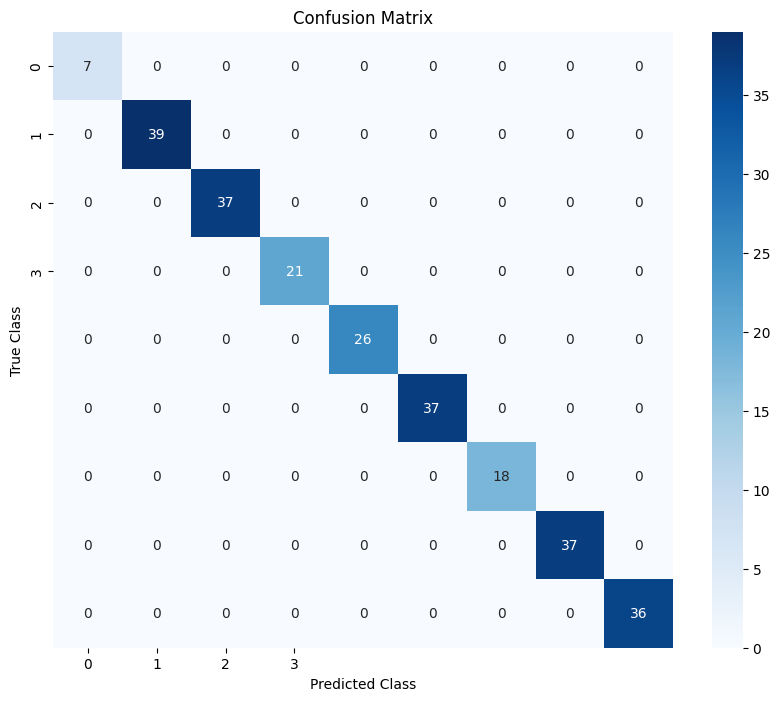

In [31]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

ROC CURVE

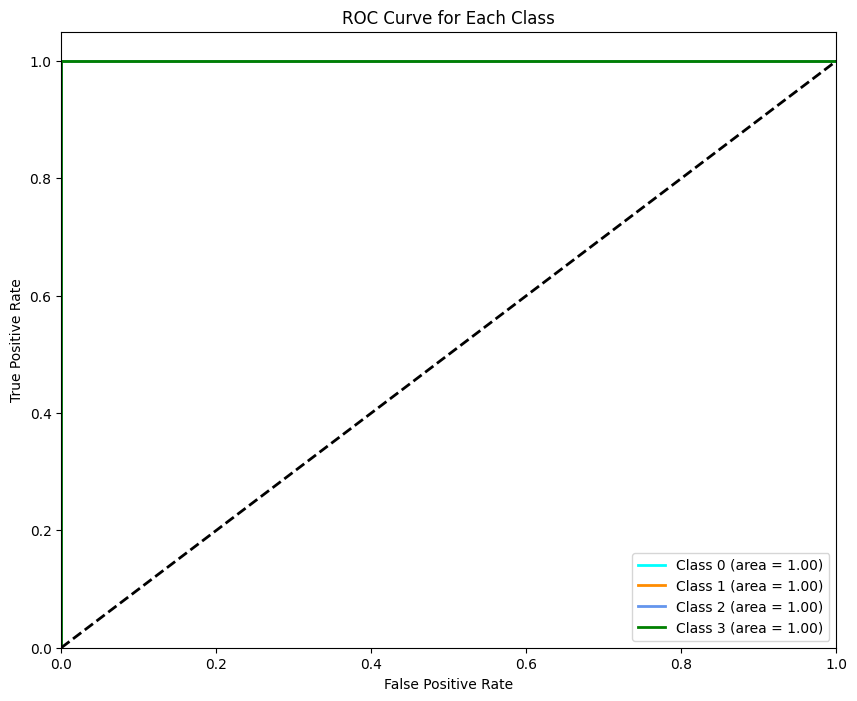

In [28]:
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

num_classes = len(label_encoders["Type"].classes_)
y_val_bin = label_binarize(y_true_classes, classes=[i for i in range(num_classes)])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

In [29]:
def predict_from_pdf(pdf_path):
    text = extract_text_from_pdf(pdf_path)
    predictions = combined_annotation(text)
    return predictions

pdf_path = '/content/Supernovae.pdf'
predictions = predict_from_pdf(pdf_path)

print(predictions)

for prediction in predictions:
    if isinstance(prediction, tuple):
        entity, label = prediction[:2]
        print(f"Entity: {entity}, Label: {label}")
    else:
        print(f"Prediction: {prediction}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[('Luminosity', '23.5 mag'), ('Luminosity', '0.1 mag'), ('Luminosity', '0.2 mag'), ('Luminosity', '0.02 mag'), ('Luminosity', '24.5 mag'), ('Type', 'Type Ia')]
Entity: Luminosity, Label: 23.5 mag
Entity: Luminosity, Label: 0.1 mag
Entity: Luminosity, Label: 0.2 mag
Entity: Luminosity, Label: 0.02 mag
Entity: Luminosity, Label: 24.5 mag
Entity: Type, Label: Type Ia
